## Project Setup

Install and load the necessary packages

In [159]:
#| echo: false
#| output: false
import os
os.environ['R_HOME'] = f'C:/Users/{os.environ.get('USERNAME')}/Miniconda3/envs/r_python_jl/Lib/R'

In [160]:
#| echo: false
#| output: false
%load_ext rpy2.ipython
# only have to run once to allow the R magic command

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


::: {.panel-tabset}

#### R

In [161]:
%%capture 
%%R

library("dplyr")
library("jsonlite")
library("tidyr")
library("REDCapR")
library("knitr")
library("remotes")
library("gt")

In [162]:
%%capture --no-display --no-stdout
%%R

version <- packageVersion("REDCapR")
version

[1] '1.1.9005'


In this project, we will use the bleeding edge version of REDCapR available on Github

In [163]:
%%capture --no-display --no-stdout
%%R

# Detach REDCapR if already loaded, and download the latest version
if (version!='1.1.9005') {
    detach("package:REDCapR", unload=TRUE)
    remotes::install_github("OuhscBbmc/REDCapR")
    library("REDCapR")
    print(packageVersion("REDCapR"))
}

else {
    print("REDCapR package up to date")
}

[1] "REDCapR package up to date"


#### Python

In [164]:
# import pycap
import redcap
import json
import pandas as pd
# import requests

:::

Assign your project URL and Token

::: {.panel-tabset}

#### R

In [178]:
%%R
path = paste0("C:/Users/", Sys.getenv("USERNAME"), '/json_api_data.json')
token <- jsonlite::fromJSON(path)$dev_token$'308'
url <- "https://dev-redcap.doh.wa.gov/api/"

#### Python

In [180]:
path_to_json = f"C:/Users/{os.environ.get('USERNAME')}/json_api_data.json"
api_key = json.load(open(path_to_json))
api_token = api_key['dev_token']['308']
api_url = api_key['dev_url']
project = redcap.Project(api_url, api_token)

:::

## Exporting Records

### Exporting Raw Data

::: {.panel-tabset}

#### R

In [280]:
%%capture 
%%R
records <- redcap_read_oneshot(
    redcap_uri = url, 
    token = token
)$data

records_tbl<- gt(head(records))
gt::gtsave(records_tbl, filename = 'export_records1.html', path = "./files/export_files/")

#### Python

In [281]:
records = project.export_records(format_type='df') #all records with raw data values
records.head(10)

redcap_repeat_instrument  \
record_id redcap_event_name                              
1         personal_info_arm_1                      NaN   
          notifications_arm_1                      NaN   
          case_intake_arm_1                        NaN   
          notifications_arm_1           close_contacts   
          notifications_arm_1           close_contacts   
2         personal_info_arm_1                      NaN   
          notifications_arm_1                      NaN   
          case_intake_arm_1                        NaN   
          case_intake_arm_1                        NaN   
          notifications_arm_1           close_contacts   

                               redcap_repeat_instance first_name last_name  \
record_id redcap_event_name                                                  
1         personal_info_arm_1                     NaN       John       Doe   
          notifications_arm_1                     NaN        NaN       NaN   
          case_intake_arm_1                       1.0        NaN       NaN   
          notifications_arm_1                     1.0        NaN       NaN   
          notifications_arm_1                     2.0        NaN       NaN   
2         personal_info_arm_1                     NaN       Jane       Doe   
          notifications_arm_1                     NaN        NaN       NaN   
          case_intake_arm_1                       1.0        NaN       NaN   
          case_intake_arm_1                       2.0        NaN       NaN   
          notifications_arm_1                     1.0        NaN       NaN   

                                    phone_num  zip_code         dob   age  \
record_id redcap_event_name                                                 
1         personal_info_arm_1  (999) 999-9999   98105.0  2006-04-11  18.0   
          notifications_arm_1             NaN       NaN         NaN   NaN   
          case_intake_arm_1               NaN       NaN         NaN   NaN   
          notifications_arm_1             NaN       NaN         NaN   NaN   
          notifications_arm_1             NaN       NaN         NaN   NaN   
2         personal_info_arm_1  (999) 999-9999   98105.0  1994-06-29  29.0   
          notifications_arm_1             NaN       NaN         NaN   NaN   
          case_intake_arm_1               NaN       NaN         NaN   NaN   
          case_intake_arm_1               NaN       NaN         NaN   NaN   
          notifications_arm_1             NaN       NaN         NaN   NaN   

                               ethnicity  race  ...        cc_phone  \
record_id redcap_event_name                     ...                   
1         personal_info_arm_1        1.0   4.0  ...             NaN   
          notifications_arm_1        NaN   NaN  ...             NaN   
          case_intake_arm_1          NaN   NaN  ...             NaN   
          notifications_arm_1        NaN   NaN  ...  (999) 999-9999   
          notifications_arm_1        NaN   NaN  ...  (999) 999-9999   
2         personal_info_arm_1        0.0   5.0  ...             NaN   
          notifications_arm_1        NaN   NaN  ...             NaN   
          case_intake_arm_1          NaN   NaN  ...             NaN   
          case_intake_arm_1          NaN   NaN  ...             NaN   
          notifications_arm_1        NaN   NaN  ...  (999) 999-9999   

                                           cc_email  close_contacts_complete  \
record_id redcap_event_name                                                    
1         personal_info_arm_1                   NaN                      NaN   
          notifications_arm_1                   NaN                      NaN   
          case_intake_arm_1                     NaN                      NaN   
          notifications_arm_1  fake_email@gmail.com                      2.0   
          notifications_arm_1  fake_email@gmail.com                      2.0   
2         personal_info_arm_1                   NaN       

When the format type=df, there is a multi-index for both the record_id and redcap_event_name. **This maybe should not be the behavior - user should choose how to set the index or have a single index for record_id.** Exporting as a csv or json creates the index from the row number and the record_id and record_event_name are regular columns of data.

:::

#### Exporting Labeled Data & Headers

Instead of exporting raw values, labeled values can be exported as well for coded values (i.e. 'male' instead of '1').

::: {.panel-tabset}

#### R

In [42]:
%%capture
%%R
data_labeled <- redcap_read_oneshot(
    redcap_uri = url, 
    token = token, 
    raw_or_label = "label", 
    raw_or_label_headers = "label")$data

data_labeled_tbl<- gt(head(data_labeled)) %>% cols_width( everything() ~ px(150))
gt::gtsave(data_labeled_tbl, filename = 'export_records2.html', path = "./files/export_files/")

#### Python

In [43]:
# tip: add `reset_index()` if you want to avoid the automatic multi-indexing of the data
data_labeled = project.export_records(raw_or_label='label', format_type='df').reset_index()
data_labeled.head(10)

,record_id,redcap_event_name,redcap_repeat_instrument,redcap_repeat_instance,first_name,last_name,phone_num,zip_code,dob,age,...,cc_phone,cc_email,close_contacts_complete,supervisor_name,supervisor_email,work_inperson_yesno,work_date,work_contagious,work_contagious_calc,work_information_complete
0,1,Personal Info,NaN,NaN,John,Doe,(999) 999-9999,98105.0,2004-12-05,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Notifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Boss,NaN,No,NaN,No,NaN,Complete
2,1,Case Intake,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Notifications,Close Contacts,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,(999) 999-9999,fake_email@gmail.com,Complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Notifications,Close Contacts,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,(999) 999-9999,fake_email@gmail.com,Complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,Personal Info,NaN,NaN,Jane,Doe,(999) 999-9999,98105.0,1995-06-29,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2,Notifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Boss,fake_email@gmail.com,Yes,2023-10-10,Yes,NaN,Complete
7,2,Case Intake,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,Case Intake,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,Notifications,Close Contacts,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,(999) 999-9999,fake_email@gmail.com,Complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN


:::

### Export Data In Batches (REDCapR Only)

::: {.panel-tabset}

#### R

A note about `redcap_read()`: From an external perspective, this function is similar to `redcap_read_oneshot()`. The internals differ in that `redcap_read()` retrieves subsets of the data, and then combines them before returning (among other objects) a single tibble::tibble(). This function can be more appropriate than `redcap_read_oneshot()` when returning large datasets that could tie up the server. [(Source)](https://ouhscbbmc.github.io/REDCapR/reference/redcap_read.html)


In [51]:
%%capture
%%R
batched_export <- redcap_read(
    redcap_uri = url, 
    token = token, 
    batch_size = 50L
)$data

In this example, the batch size was set to 50 records. The default is 100 records. The data exported using this method has the exact same format as `redcap_read_oneshot`.

:::

### Filtering Exported Records

Although the REDCapR and Pycap functions have options for filtering data upon export, for smaller datasets, we recommend exporting the entire data set, then filter it R or Python functions. See the appendix @sec-filtering for more information. 

If a project has a large amount of data that is burdensome to export all together, then we recommend using REDCapR/Pycap functions to filter the data during export.

Creating custom reports within REDCap and then exporting those filtered reports, is another option for filtering the data before export for projects with a large amount of data. See @sec-reports

### Exporting the next available record_id

When a project is set up in REDCap it has **Auto-numbering for records** enabled by default. This allows a new and unique record_id to be automatically assigned every time you enter a new record. Before importing new records you may want to know what the next available record_id is to ensure you are assigning new record_id's to these new records before import (rather than overwriting an existing record). 

::: {.panel-tabset}

#### R

In [52]:
%%R
next_record <- redcap_next_free_record_name(
    redcap_uri = url, 
    token = token, 
    verbose = TRUE,
    config_options = NULL)

next_record

R[write to console]: The next free record name in REDCap was successfully determined in 0.3 seconds.  The http status code was 200.  Is is 7.



[1] "7"


#### Python

In [53]:
project.generate_next_record_name()

'7'

:::

## Reports {#sec-reports}

To export reports via API you will need the 'Report ID' of your desired report. You can find the 'Report ID' of the report you want to export by going to your REDCap project and selecting "Data Export, Reports, and Stats" then "My Reports & Exports".
![report](./files/REDCAp_project.png){width=700, fig-align="center"}

### Exporting Raw Reports

::: {.panel-tabset}

#### R

In [54]:
%%capture
%%R
cases_oct_2023 <- redcap_report(
    redcap_uri = url, 
    token = token, 
    report_id = 2178
)$data

tbl<- gt(head(cases_oct_2023))
gt::gtsave(tbl, filename = 'export_reports1.html',  path = "./files/")

#### Python

In [56]:
project.export_report(report_id='2178', format_type='df', raw_or_label='raw').head(7)

redcap_repeat_instrument  \
record_id redcap_event_name                               
1         notifications_arm_1                       NaN   
          personal_info_arm_1                       NaN   
          case_intake_arm_1                         NaN   
2         notifications_arm_1                       NaN   
          personal_info_arm_1                       NaN   
          case_intake_arm_1                         NaN   
          case_intake_arm_1                         NaN   

                               redcap_repeat_instance first_name last_name  \
record_id redcap_event_name                                                  
1         notifications_arm_1                     NaN        NaN       NaN   
          personal_info_arm_1                     NaN       John       Doe   
          case_intake_arm_1                       1.0        NaN       NaN   
2         notifications_arm_1                     NaN        NaN       NaN   
          personal_info_arm_1                     NaN       Jane       Doe   
          case_intake_arm_1                       2.0        NaN       NaN   
          case_intake_arm_1                       1.0        NaN       NaN   

                                    phone_num  zip_code         dob   age  \
record_id redcap_event_name                                                 
1         notifications_arm_1             NaN       NaN         NaN   NaN   
          personal_info_arm_1  (999) 999-9999   98105.0  2004-12-05  18.0   
          case_intake_arm_1               NaN       NaN         NaN   NaN   
2         notifications_arm_1             NaN       NaN         NaN   NaN   
          personal_info_arm_1  (999) 999-9999   98105.0  1995-06-29  28.0   
          case_intake_arm_1               NaN       NaN         NaN   NaN   
          case_intake_arm_1               NaN       NaN         NaN   NaN   

                               ethnicity  race  ...  symptoms_yesno  \
record_id redcap_event_name                     ...                   
1         notifications_arm_1        NaN   NaN  ...             NaN   
          personal_info_arm_1        1.0   4.0  ...             NaN   
          case_intake_arm_1          NaN   NaN  ...             1.0   
2         notifications_arm_1        NaN   NaN  ...             NaN   
          personal_info_arm_1        0.0   5.0  ...             NaN   
          case_intake_arm_1          NaN   NaN  ...             1.0   
          case_intake_arm_1          NaN   NaN  ...             1.0   

                               symptom_onset     symptoms_exp symptom_notes  \
record_id redcap_event_name                                                   
1         notifications_arm_1            NaN              NaN           NaN   
          personal_info_arm_1            NaN              NaN           NaN   
          case_intake_arm_1       2023-10-09            1,2,7           NaN   
2         notifications_arm_1            NaN              NaN           NaN   
          personal_info_arm_1            NaN              NaN           NaN   
          case_intake_arm_1       2021-06-05  1,2,3,4,5,7,8,9           NaN   
          case_intake_arm_1       2023-10-11            1,2,8           NaN   

                               test_yesno  test_positive_yesno  \
record_id redcap_event_name                                      
1         notifications_arm_1         NaN                  NaN   
          personal_info_arm_1         NaN                  NaN   
          case_intake_arm_1           1.0                  1.0   
2         notifications_arm_1         NaN                  NaN   
          personal_info_arm_1         NaN                  NaN   
          case_intake_arm_1           1.0                  1.0   
          case_intake_arm_1           1.0                  1.0   

                               test_positive_date                test_upload  \
record_id redcap_event_name                                                

:::

### Exporting Labelled Reports
Reports can also be exported as labeled data for readability.

::: {.panel-tabset}

#### R

In [57]:
%%capture
%%R
cases_oct_2023_labeled <- redcap_report(
    redcap_uri = url, 
    token = token,
    report_id = 2178, 
    raw_or_label = 'label'
)$data

In [58]:
%%R
tbl<- gt(head(cases_oct_2023_labeled))
gt::gtsave(tbl, filename = 'export_reports2.html', path = "./files/")

#### Python

In [59]:
project.export_report(report_id='2178', format_type='df', raw_or_label='label').head(7)

redcap_repeat_instrument  redcap_repeat_instance  \
record_id redcap_event_name                                                     
1         Notifications                           NaN                     NaN   
          Personal Info                           NaN                     NaN   
          Case Intake                             NaN                     1.0   
2         Notifications                           NaN                     NaN   
          Personal Info                           NaN                     NaN   
          Case Intake                             NaN                     2.0   
          Case Intake                             NaN                     1.0   

                            first_name last_name       phone_num  zip_code  \
record_id redcap_event_name                                                  
1         Notifications            NaN       NaN             NaN       NaN   
          Personal Info           John       Doe  (999) 999-9999   98105.0   
          Case Intake              NaN       NaN             NaN       NaN   
2         Notifications            NaN       NaN             NaN       NaN   
          Personal Info           Jane       Doe  (999) 999-9999   98105.0   
          Case Intake              NaN       NaN             NaN       NaN   
          Case Intake              NaN       NaN             NaN       NaN   

                                    dob   age               ethnicity  \
record_id redcap_event_name                                             
1         Notifications             NaN   NaN                     NaN   
          Personal Info      2004-12-05  18.0  NOT Hispanic or Latino   
          Case Intake               NaN   NaN                     NaN   
2         Notifications             NaN   NaN                     NaN   
          Personal Info      1995-06-29  28.0      Hispanic or Latino   
          Case Intake               NaN   NaN                     NaN   
          Case Intake               NaN   NaN                     NaN   

                                           race  ... symptoms_yesno  \
record_id redcap_event_name                      ...                  
1         Notifications                     NaN  ...            NaN   
          Personal Info                   White  ...            NaN   
          Case Intake                       NaN  ...            Yes   
2         Notifications                     NaN  ...            NaN   
          Personal Info      More Than One Race  ...            NaN   
          Case Intake                       NaN  ...            Yes   
          Case Intake                       NaN  ...            Yes   

                            symptom_onset  \
record_id redcap_event_name                 
1         Notifications               NaN   
          Personal Info               NaN   
          Case Intake          2023-10-09   
2         Notifications               NaN   
          Personal Info               NaN   
          Case Intake          2021-06-05   
          Case Intake          2023-10-11   

                                                                  symptoms_exp  \
record_id redcap_event_name                                                      
1         Notifications                                                    NaN   
          Personal Info                                                    NaN   
          Case Intake                             Sore Throat,Cough,Congestion   
2         Notifications                                                    NaN   
          Personal Info                                                    NaN   
          Case Intake        Sore Throat,Cough,Shortness of Breath,Chest Pa...   
          Case Intake                                  Sore Throat,Cough,Fever   

                            symptom_notes  test_yesno test_positive_yesno  \
record_id redcap_event_name                                                 

:::

## Files: Attachments to Individual Records

File uploads are a unique field type in REDCap that accept a variety of file types, including images and other documents. Unlike other export methods, exporting files only works for one file field from one record at a time. 

If the project has repeating events (i.e. a longitudinal project), the event name must be specified. If the file of interest is in a repeat instance, the instance number must also be specified.

::: {.panel-tabset}

#### R

In [60]:
%%capture
%%R
redcap_file_download_oneshot(
    event = "case_intake_arm_1",
    directory = "./files/export_files/",
    file_name = "test_file_export_r.png",
    record = 1,
    field = "test_upload",
    redcap_uri = url,
    token = token,
    overwrite = TRUE
)

![file_r](./files/export_files/test_file_export_r.png){width=700, fig-align="center"}

#### Python

The following code can be used to save and display the file in the format we expect:

In [61]:
export_file_image = project.export_file(record="1", 
                                        field="test_upload", 
                                        event="case_intake_arm_1")
with open("files/export_files/test_file_export_py.png","wb") as binary_file:
    binary_file.write(export_file_image[0])

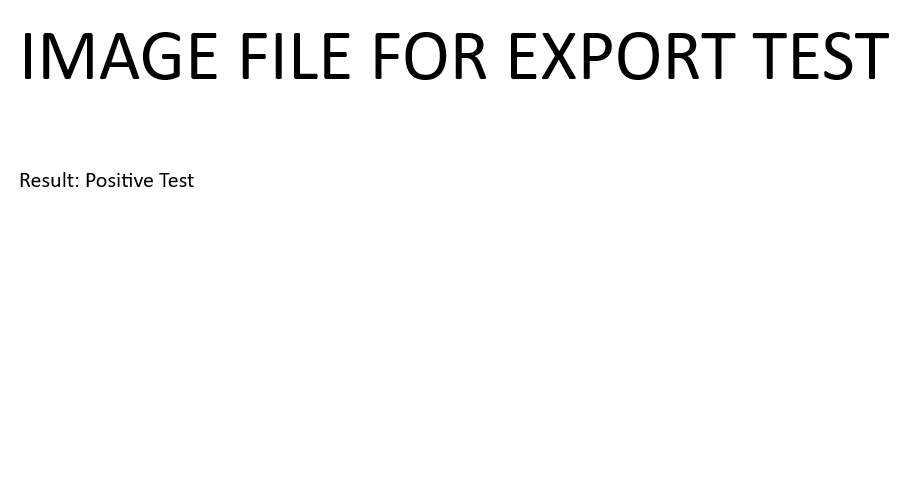

In [62]:
from IPython.display import Image
Image("files/export_files/test_file_export_py.png", width=400)

:::

## Survey Metadata

::: {.panel-tabset}

#### R

In [63]:
%%capture
%%R
metadata <- redcap_metadata_read(
    redcap_uri = url, 
    token = token
)$data

metadata_tbl<- gt(head(metadata))
gt::gtsave(data_tbl, filename = 'metadata.html', path = "./files/export_files/")

#### Python

In [64]:
project.export_metadata(format_type="df").head(10)

,form_name,section_header,field_type,field_label,select_choices_or_calculations,field_note,text_validation_type_or_show_slider_number,text_validation_min,text_validation_max,identifier,branching_logic,required_field,custom_alignment,question_number,matrix_group_name,matrix_ranking,field_annotation
field_name,,,,,,,,,,,,,,,,,
record_id,demographics,NaN,text,Record ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_name,demographics,Personal Information,text,First Name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_name,demographics,NaN,text,Last Name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone_num,demographics,NaN,text,Phone Number,NaN,NaN,phone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip_code,demographics,NaN,text,ZIP Code,NaN,NaN,integer,10001.0,99999,y,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dob,demographics,NaN,text,Date of birth,NaN,NaN,date_mdy,NaN,NaN,y,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,demographics,NaN,calc,Age (years),"rounddown(datediff([dob],'today','y'))",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,demographics,NaN,radio,Ethnicity,"0, Hispanic or Latino|1, NOT Hispanic or Latin...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,LH,NaN,NaN,NaN,NaN
race,demographics,NaN,dropdown,Race,"0, American Indian/Alaska Native|1, Asian|2, N...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


:::

## Field Names

::: {.panel-tabset}

#### R

In [65]:
%%capture
%%R
field_names <- redcap_variables(
    redcap_uri = url, 
    token = token, 
    verbose = TRUE, 
    config_options = NULL
)$data

field_names_tbl<- gt(head(field_names,15))
gt::gtsave(field_names_tbl, filename = 'field_names.html', path = "./files/export_files/")

#### Python

In [66]:
project.export_field_names(format_type="df").head(15)

,choice_value,export_field_name
original_field_name,,
record_id,NaN,record_id
first_name,NaN,first_name
last_name,NaN,last_name
phone_num,NaN,phone_num
zip_code,NaN,zip_code
dob,NaN,dob
age,NaN,age
ethnicity,NaN,ethnicity
race,NaN,race


:::

## Forms and Instruments {#sec-forms_instruments}

### Instrument Names and Labels

**Note:** Use the value specified under `instrument_name` (not `instrument_label`) when specifying specific instruments as arguments in REDCapR and Pycap functions.

::: {.panel-tabset}

#### R

In [67]:
%%capture
%%R
instruments <- redcap_instruments(
    redcap_uri = url, 
    token = token, 
    verbose = TRUE, 
    config_options = NULL
)$data

instruments_tbl<- gt(head(instruments))
gt::gtsave(instruments_tbl, filename = 'instruments.html', path = "./files/export_files/")

#### Python

In [68]:
project.export_instruments(format_type = "df")

,instrument_name,instrument_label
0,demographics,Demographics
1,symptoms,Symptoms
2,test_information,Test Information
3,close_contacts,Close Contacts
4,work_information,Work Information


:::

### Download PDF of Instruments

These functions will download the instrument specified and all of the fields as a cleanly formatted questionnaire pdf file. 

::: {.panel-tabset}

#### R

In [69]:
%%capture
%%R
redcap_instrument_download(
    instrument = "symptoms",
    directory = "./files/instruments/",
    file_name = "symptoms_instrument.pdf",
    redcap_uri = url,
    overwrite = TRUE,
    token = token
)

#### Python

In [70]:
close_contact  = project.export_pdf(instrument = 'close_contacts')
with open("files/instruments/close_contacts.pdf","wb") as binary_file:
    binary_file.write(close_contact[0])

In [95]:
from IPython.display import IFrame
IFrame("files/instruments/close_contacts.pdf", width=800, height=300)

:::

## Instrument/Event Map

The Instrument/Event map is a quick way to see what instruments are associated with which events in longitudinal REDCap projects

::: {.panel-tabset}

#### R

In [165]:
%%capture
%%R
final_mapping <- redcap_event_instruments(
    redcap_uri = url, 
    token, 
    verbose = TRUE, 
    config_options = NULL
)$data

final_mapping_tbl<- gt(head(final_mapping))
gt::gtsave(final_mapping_tbl, filename = 'export_instrument_event.html', path = "./files/export_files/")

#### Python

In [167]:
project.export_instrument_event_mappings(format_type='df')

,arm_num,unique_event_name,form
0,1,personal_info_arm_1,demographics
1,1,case_intake_arm_1,symptoms
2,1,case_intake_arm_1,test_information
3,1,notifications_arm_1,close_contacts
4,1,notifications_arm_1,work_information


:::

**Note:** Events with multiple instruments will occupy multiple rows, with one row per instrument. 

## Survey Settings and Other Information

### Users and User Roles

::: {.panel-tabset}

#### R

In [101]:
%%capture --no-display --no-stdout
%%R
users_data <- redcap_users_export(redcap_uri = url, token = token)
names(users_data)

[1] "data_user"       "data_user_form"  "success"         "status_code"    
[5] "outcome_message" "elapsed_seconds" "raw_text"       


`redcap_users_export` output provides a list with several elements. The two most useful elements are the "data_user" and the "data_user_form". 

##### Extract the data_user table to see users who have access to the project:

In [102]:
%%capture
%%R
users <- users_data$data_user

users_tbl<- gt(head(users))
gt::gtsave(users_tbl, filename = 'export_users1.html', path = "./files/export_files/")

There does not appear to be a way to export which user is in which named user role group with REDCapR or the native API. When you export this data, if a user has been assigned to a user role then it will return the user with the role's defined privileges.

##### Extract the data_user_form table to see which forms each users has access to:

In [103]:
%%capture
%%R
users_forms <- users_data$data_user_form

users_forms_tbl<- gt(head(users_forms))
gt::gtsave(users_forms_tbl, filename = 'export_users2.html', path = "./files/export_files/")

#### Python

In [104]:
project.export_users(format_type='df') 

,username,email,firstname,lastname,expiration,data_access_group,data_access_group_id,design,alerts,user_rights,...,mobile_app,mobile_app_download_data,record_create,record_rename,record_delete,lock_records_all_forms,lock_records,lock_records_customization,forms,forms_export
0,alexey.gilman@doh.wa.gov,Alexey.Gilman@doh.wa.gov,Alexey,Gilman,NaN,records1_2,2716.0,0,0,1,...,1,1,1,1,1,1,0,1,"demographics:3,symptoms:1,test_information:3,c...","demographics:1,symptoms:1,test_information:1,c..."
1,caitlin.drover@doh.wa.gov,Caitlin.Drover@doh.wa.gov,Caitlin,Drover,NaN,NaN,NaN,1,1,1,...,1,0,1,1,1,0,0,1,"demographics:1,symptoms:1,test_information:1,c...","demographics:1,symptoms:1,test_information:1,c..."
2,emily.pearman@doh.wa.gov,emily.pearman@doh.wa.gov,Emily,Pearman,NaN,NaN,NaN,1,1,1,...,1,1,1,1,1,0,0,0,"demographics:1,symptoms:1,test_information:1,c...","demographics:1,symptoms:1,test_information:1,c..."


In [105]:
project.export_user_roles(format_type='df') 

,unique_role_name,role_label,design,alerts,user_rights,data_access_groups,reports,stats_and_charts,manage_survey_participants,calendar,...,mobile_app,mobile_app_download_data,record_create,record_rename,record_delete,lock_records_customization,lock_records,lock_records_all_forms,forms,forms_export
0,U-5354FA3HYL,Admin,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,0,0,"demographics:1,symptoms:1,test_information:1,c...","demographics:1,symptoms:1,test_information:1,c..."


In [106]:
project.export_user_role_assignment(format_type='df')

,username,unique_role_name,data_access_group
0,alexey.gilman@doh.wa.gov,NaN,records1_2
1,caitlin.drover@doh.wa.gov,U-5354FA3HYL,NaN
2,emily.pearman@doh.wa.gov,NaN,NaN


You can use the "unique_role_name" field from `export_user_roles` to see which user is assigned to which user role in the ouput of `export_user_role_assignment`

:::

### Data Access Groups (DAGs)

In addition to user roles for access control, DAGs control which records each user can access. Users assigned to a DAG can only access records assigned to that group, and are blinded to records outside of their group. DAGs are particularly useful in multi-site or multi-jurisdictional projects to restrict sites from viewing records from other sites.  

Users can be assigned to a DAG after being added to the project. Users can be in multiple DAGs. Users not assigned to any DAG have global access and can see all records in the project. 

::: {.panel-tabset}

#### R

View the Dags and their unique 'data_access_group_id'

In [107]:
%%capture
%%R 
dag <- redcap_dag_read(redcap_uri = url, token)$data

dag_tbl<- gt(head(dag))
gt::gtsave(dag_tbl, filename = 'export_dag1.html', path = "./files/export_files/")

Use `redcap_read_oneshot` to view which records belong to which data access group.

In [112]:
%%capture
%%R
data_dag <- redcap_read_oneshot(
    redcap_uri = url, 
    token = token,
    export_data_access_groups = TRUE, 
    fields = "record_id")$data

data_dag_tbl<- gt(head(data_dag))
gt::gtsave(data_dag_tbl, filename = 'export_dag2.html', path = "./files/export_files/")

Even though only 'record_id' was specified for export under the 'fields' argument, Pycap will automatically include all the variables that make the unique_key (record_id, redcap_event_name, redcap_repeat_instrument, redcap_repeat_instance).

For the REDCapR package, refer to the `data_user` table printed in the section above to see which user is assigned to which DAG group. 

#### Python

View the Dags and their unique 'data_access_group_id'

In [109]:
project.export_dags(format_type='df') 

,data_access_group_name,unique_group_name,data_access_group_id
0,Limited Access,limited_access,2707
1,records1_2,records1_2,2716


View which user is assigned to which DAG group

In [110]:
project.export_user_dag_assignment(format_type='df') #exports users and their assigned DAGs (username and DAG)

,username,redcap_data_access_group
0,alexey.gilman@doh.wa.gov,records1_2
1,caitlin.drover@doh.wa.gov,NaN
2,emily.pearman@doh.wa.gov,NaN


Use `export_records` to view which records belong to which data access group.

In [117]:
dag = project.export_records(format_type = 'df', export_data_access_groups = True, fields = 'record_id')
dag.head()

redcap_repeat_instrument  \
record_id redcap_event_name                               
1         personal_info_arm_1                       NaN   
          notifications_arm_1                       NaN   
          case_intake_arm_1                         NaN   
2         personal_info_arm_1                       NaN   
          notifications_arm_1                       NaN   

                               redcap_repeat_instance redcap_data_access_group  
record_id redcap_event_name                                                     
1         personal_info_arm_1                     NaN               records1_2  
          notifications_arm_1                     NaN               records1_2  
          case_intake_arm_1                       1.0               records1_2  
2         personal_info_arm_1                     NaN               records1_2  
          notifications_arm_1                     NaN               records1_2

Even though only 'record_id' was specified for export under the 'fields' argument, Pycap will automatically include all the variables that make the unique_key (record_id, redcap_event_name, redcap_repeat_instrument, redcap_repeat_instance).

:::

### Logging

The REDCap log provides an audit trail to track record creation, deletion, update and export. It also tracks changes made to the survey design and user rights.

::: {.panel-tabset}

#### R

The `redcap_log_read` function is only available on REDCapR Version 1.1.9 and later.

In [196]:
%%capture
%%R

log <- redcap_log_read(redcap_uri = url, token)$data

log_tbl<- gt(head(log))
gt::gtsave(log_tbl, filename = 'export_log.html', path = "./files/export_files/")

#### Python

In [143]:
log = project.export_logging(format_type='df')
log.head()

,timestamp,username,action,details,record
0,2024-04-09 16:17,emily.pearman@doh.wa.gov,Manage/Design,Export Logging (API),NaN
1,2024-04-09 16:17,emily.pearman@doh.wa.gov,Manage/Design,Export Logging (API),NaN
2,2024-04-09 16:17,emily.pearman@doh.wa.gov,Manage/Design,Export Logging (API),NaN
3,2024-04-09 16:11,emily.pearman@doh.wa.gov,Manage/Design,Export Logging (API),NaN
4,2024-04-09 16:06,emily.pearman@doh.wa.gov,Manage/Design,Export Logging (API),NaN


:::

### Survey Link (REDCapR Only)

::: {.panel-tabset}

#### R

To export the survey link, the instrument must be enabled as a survey in REDCap. If it is a longitudinal survey, you must specify the event name (and instance if repeating) along with the instrument name. This export can only return a survey link for already existing records.

In [194]:
%%capture
%%R 

link <- redcap_survey_link_export_oneshot(
    record = 6,
    instrument = "test_information",
    redcap_uri = url,
    token = token,
    event = "case_intake_arm_1"
)
result$survey_link

In [195]:
%%R

link$survey_link

[1] "https://dev-redcap.doh.wa.gov/surveys/?s=k4z7SZWpuKBi4mQt"


:::

### REDCap Version

::: {.panel-tabset}

#### R

In [200]:
%%R
redcap_version(
  url,
  token, 
  verbose = TRUE, 
  config_options = NULL
)

R[write to console]: The REDCap version was successfully determined in 0.2 seconds. The http status code was 200.  Is is 14.0.18.



[1] '14.0.18'


#### Python

In [202]:
project.export_version()

Version('14.0.18')

:::

## Appendix

### Filtering Data {#sec-filtering}


#### Filtering by record_id 

Export data for record 1 and 2 only using REDCapR

::: {.panel-tabset}

#### R

In [212]:
%%capture
%%R
data_by_record <- redcap_read_oneshot(
    records = c(1,2), 
    redcap_uri = url, 
    token = token
)$data

data_by_record_tbl<- gt(head(data_by_record))
gt::gtsave(data_by_record_tbl, filename = 'export_records_filtered_2.html', path = "./files/export_files/")

You can also export the entire data set and filter by record_id after. The code below will give the same result. 

In [271]:
%%capture
%%R
data <- redcap_read_oneshot(
    redcap_uri = url, 
    token = token
)$data

data_by_record2 <- data %>% filter(record_id == 1 | record_id == 2)

#### Python

In [221]:
project.export_records(records=['1','2'],
                       raw_or_label='label',
                       format_type='df'
                      ).reset_index()

,record_id,redcap_event_name,redcap_repeat_instrument,redcap_repeat_instance,first_name,last_name,phone_num,zip_code,dob,age,...,cc_phone,cc_email,close_contacts_complete,supervisor_name,supervisor_email,work_inperson_yesno,work_date,work_contagious,work_contagious_calc,work_information_complete
0,1,Personal Info,NaN,NaN,John,Doe,(999) 999-9999,98105.0,2006-04-11,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Notifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Boss,NaN,No,NaN,No,NaN,Complete
2,1,Case Intake,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Notifications,Close Contacts,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,(999) 999-9999,fake_email@gmail.com,Complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Notifications,Close Contacts,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,(999) 999-9999,fake_email@gmail.com,Complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,Personal Info,NaN,NaN,Jane,Doe,(999) 999-9999,98105.0,1994-06-29,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2,Notifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Boss,fake_email@gmail.com,Yes,2023-10-10,Yes,NaN,Complete
7,2,Case Intake,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,Case Intake,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,Notifications,Close Contacts,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,(999) 999-9999,fake_email@gmail.com,Complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You can also export the entire data set and filter by record_id after. The code below will give the same result. 

In [279]:
#| echo: false
#| output: false
records = project.export_records(
                       raw_or_label='label',
                       format_type='df'
                      ).reset_index(
                      )

records[records["record_id"].isin([1,2])]

,record_id,redcap_event_name,redcap_repeat_instrument,redcap_repeat_instance,first_name,last_name,phone_num,zip_code,dob,age,...,cc_phone,cc_email,close_contacts_complete,supervisor_name,supervisor_email,work_inperson_yesno,work_date,work_contagious,work_contagious_calc,work_information_complete
0,1,Personal Info,NaN,NaN,John,Doe,(999) 999-9999,98105.0,2006-04-11,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Notifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Boss,NaN,No,NaN,No,NaN,Complete
2,1,Case Intake,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Notifications,Close Contacts,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,(999) 999-9999,fake_email@gmail.com,Complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Notifications,Close Contacts,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,(999) 999-9999,fake_email@gmail.com,Complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,Personal Info,NaN,NaN,Jane,Doe,(999) 999-9999,98105.0,1994-06-29,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2,Notifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Boss,fake_email@gmail.com,Yes,2023-10-10,Yes,NaN,Complete
7,2,Case Intake,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,Case Intake,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,Notifications,Close Contacts,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,(999) 999-9999,fake_email@gmail.com,Complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN


:::

#### By Date

Filtering export by Date Record Was Added or Modified
In the following example we will view all records that were modified or added after April 9, 2024. For more information on how this records were modified you can view the REDCap log.

This is particularly useful as filtering by date the record was modified or added cannot be done after record export without linking the records to the REDCap log. 

::: {.panel-tabset}

#### R

In [206]:
%%capture
%%R
data_by_date <- redcap_read_oneshot(
    redcap_uri = url, 
    token = token, 
    datetime_range_begin = as.POSIXct("2024/04/09", 
                                    format = "%Y/%m/%d")
)$data

data_by_date_tbl<- gt(head(data_by_date))
gt::gtsave(data_by_date_tbl, filename = 'export_records_filtered_1.html', path = "./files/export_files/")


**Note:** Need to specify date format as seen above using [as.POSIXct](https://rdrr.io/r/base/as.POSIXlt.html)

#### Python

In [208]:
from datetime import datetime
project.export_records(date_begin=datetime.fromisoformat("2024-04-09"), 
                       format_type='df')

redcap_repeat_instrument  \
record_id redcap_event_name                              
1         personal_info_arm_1                      NaN   
          notifications_arm_1                      NaN   
          case_intake_arm_1                        NaN   
          notifications_arm_1           close_contacts   
          notifications_arm_1           close_contacts   
2         personal_info_arm_1                      NaN   
          notifications_arm_1                      NaN   
          case_intake_arm_1                        NaN   
          case_intake_arm_1                        NaN   
          notifications_arm_1           close_contacts   
          notifications_arm_1           close_contacts   
3         personal_info_arm_1                      NaN   
          notifications_arm_1                      NaN   
          case_intake_arm_1                        NaN   
          notifications_arm_1           close_contacts   
          notifications_arm_1           close_contacts   

                               redcap_repeat_instance first_name last_name  \
record_id redcap_event_name                                                  
1         personal_info_arm_1                     NaN       John       Doe   
          notifications_arm_1                     NaN        NaN       NaN   
          case_intake_arm_1                       1.0        NaN       NaN   
          notifications_arm_1                     1.0        NaN       NaN   
          notifications_arm_1                     2.0        NaN       NaN   
2         personal_info_arm_1                     NaN       Jane       Doe   
          notifications_arm_1                     NaN        NaN       NaN   
          case_intake_arm_1                       1.0        NaN       NaN   
          case_intake_arm_1                       2.0        NaN       NaN   
          notifications_arm_1                     1.0        NaN       NaN   
          notifications_arm_1                     2.0        NaN       NaN   
3         personal_info_arm_1                     NaN       John       Doe   
          notifications_arm_1                     NaN        NaN       NaN   
          case_intake_arm_1                       1.0        NaN       NaN   
          notifications_arm_1                     1.0        NaN       NaN   
          notifications_arm_1                     2.0        NaN       NaN   

                                    phone_num  zip_code         dob   age  \
record_id redcap_event_name                                                 
1         personal_info_arm_1  (999) 999-9999   98105.0  2006-04-11  18.0   
          notifications_arm_1             NaN       NaN         NaN   NaN   
          case_intake_arm_1               NaN       NaN         NaN   NaN   
          notifications_arm_1             NaN       NaN         NaN   NaN   
          notifications_arm_1             NaN       NaN         NaN   NaN   
2         personal_info_arm_1  (999) 999-9999   98105.0  1994-06-29  29.0   
          notifications_arm_1             NaN       NaN         NaN   NaN   
          case_intake_arm_1               NaN       NaN         NaN   NaN   
          case_intake_arm_1               NaN       NaN         NaN   NaN   
          notifications_arm_1             NaN       NaN         NaN   NaN   
          notifications_arm_1             NaN       NaN         NaN   NaN   
3         personal_info_arm_1  (999) 999-9999   98105.0         NaN   NaN   
          notifications_arm_1             NaN       NaN         NaN   NaN   
          case_intake_arm_1               NaN       NaN         NaN   NaN   
          notifications_arm_1             NaN       NaN         NaN   NaN   
          notifications_arm_1             NaN       NaN         NaN   NaN   

                               ethnicity  race  ...        cc_phone  \
record_id redcap_event_name                     ...                   
1         personal_info_arm_1        1.0   4.0  ...

:::

#### Filtering export by a specific field's value

ex. Filter by Gender 

::: {.panel-tabset}

#### R

In [231]:
%%capture
%%R
data_by_gender <- redcap_read_oneshot(
    redcap_uri = url, 
    token = token,
    filter_logic = "[gender] = '0'" 
)$data %>%
 select(c(record_id, gender))

data_by_gender_tbl<- gt(head(data_by_gender))
gt::gtsave(data_by_gender_tbl, filename = 'export_records_filtered_3.html', path = "./files/export_files/")

**Note:** When filtering on REDCap multiple choice variables, yes/no variables, and checkboxes, you must put quotes around the coded value when using the `filter_logic` argument, otherwise REDCap will not perform the filtering correctly. 

#### Python

In [236]:
project.export_records(filter_logic="[gender] = 0", 
                       format_type='df'
                      ).reset_index()[['record_id', 'gender']]

,record_id,gender
0,2,0
1,4,0
2,6,0


:::

ex Filter by Age 

::: {.panel-tabset}

#### R

In [234]:
%%capture
%%R
data_by_age <- redcap_read_oneshot(
    redcap_uri = url, 
    token = token, 
    filter_logic = "[age] > 20 " 
)$data%>%
 select(c(record_id, age))

data_by_age_tbl<- gt(head(data_by_age))
gt::gtsave(data_by_age_tbl, filename = 'export_records_filtered_4.html', path = "./files/export_files/")

**Note:** Because age is a numeric field in REDCap, it does not need quotes around the number 20 in this example.

#### Python

In [235]:
project.export_records(filter_logic="[age] > 20", 
                       format_type='df'
                      ).reset_index()[['record_id', 'age']]

,record_id,age
0,2,29
1,4,28
2,5,34
3,6,25


:::

### Export specific fields

ex. Export name fields

::: {.panel-tabset}

#### R

In [239]:
%%capture
%%R
#specifying record_id automatically also pulls the event, instrument and instance columns (when applicable).
field_subset_1 <- redcap_read_oneshot(
    fields = c("record_id","first_name","last_name"), 
    redcap_uri = url, 
    token = token
)$data

field_subset_1_tbl<- gt(head(field_subset_1))
gt::gtsave(field_subset_1_tbl, filename = 'export_records5.html', path = "./files/export_files/")

**Note:** if record_id is not specified, no identifier fields will be exported and only the specific fields listed will be returned.

#### Python

In [278]:
#| echo: false
#| output: false

project.export_records(records=['3','4'], 
                       fields=["first_name","last_name"],
                       format_type='df')

redcap_repeat_instrument  \
record_id redcap_event_name                               
3         personal_info_arm_1                       NaN   
          notifications_arm_1                       NaN   
          case_intake_arm_1                         NaN   
4         personal_info_arm_1                       NaN   
          notifications_arm_1                       NaN   
          case_intake_arm_1                         NaN   
          case_intake_arm_1                         NaN   

                               redcap_repeat_instance first_name last_name  
record_id redcap_event_name                                                 
3         personal_info_arm_1                     NaN       John       Doe  
          notifications_arm_1                     NaN        NaN       NaN  
          case_intake_arm_1                       1.0        NaN       NaN  
4         personal_info_arm_1                     NaN       Jane       Doe  
          notifications_arm_1                     NaN        NaN       NaN  
          case_intake_arm_1                       1.0        NaN       NaN  
          case_intake_arm_1                       2.0        NaN       NaN

**Note:** if record_id is not specified, all fields that make up the unique key will still be exported.

:::

### Export only specific instruments

See @sec-forms_instruments for how to use the `redcap_instruments` function to get a list of instrument names.

::: {.panel-tabset}

#### R

In [263]:
%%capture
%%R

records_dem <- redcap_read_oneshot(redcap_uri = url, 
                           fields = "record_id",
                           forms = "symptoms", 
                           token = token
                                       )$data

records_dem_tbl <- gt(head(records_dem))
gt::gtsave(records_dem_tbl, filename = 'export_records6.html', path = "./files/export_files/")

You must add `record_id` to the `fields_collapsed` argument for the data to export with the `record_id` attached. This API call will export all rows (including rows not relevant to the desired instrument). However, this is still useful because it only exports fields in that instrument and you can further filter the data to include only rows for that instrument.

In [264]:
%%capture
%%R
records_dem_final <- records_dem %>% filter(!is.na(symptoms_complete))

records_dem_final_tbl <- gt(head(records_dem_final))
gt::gtsave(records_dem_final_tbl, filename = 'export_records7.html', path = "./files/export_files/")

Using the "demographics_complete" field that REDCap automoatically generates to filter rows to just those relevant to that instrument.

You can also filter the data upon export.

In [265]:
%%capture
%%R

records_dem_final2 <- redcap_read_oneshot(redcap_uri = url, 
                           fields = "record_id",
                           forms = "symptoms", 
                           filter_logic = '[symptoms_complete] <> ""',
                           token = token
                                       )$data

records_dem_final2_tbl <- gt(head(records_dem_final2))
gt::gtsave(records_dem_final2_tbl, filename = 'export_records8.html', path = "./files/export_files/")

#### Python

:::

::: {.panel-tabset}

#### R

#### Python

:::

::: {.panel-tabset}

#### R

#### Python

:::

::: {.panel-tabset}

#### R

#### Python

:::

In [ ]:
symptoms_wrapper

### Filtering Data Using R

#### Filter by Date Record Was Added or Modified

##### Filtering Data Based on record_id

ex. Filter all exported data for record 1 and 2 only using R

In [ ]:
record_subset_v2 <- Data %>% filter(record_id == 1 | record_id == 2)
head(record_subset_v2)

#### Filtering for Certain Fields of Data 

##### ex. Filter all exported data for name fields using R

In [ ]:
#selecting columns in R will only keep the columns explicity listed
field_subset_v2 <- Data %>% select("record_id","first_name","last_name")
head(field_subset_v2)

#### Filtering Data Based on Field Values

##### ex. Filter all exported data for female participants

In [ ]:
female_records <- Data_labeled %>% inner_join(Data %>% filter(gender == 0) %>% select(record_id), by = 'record_id')
# or just "female_records = Data %>% filter(gender == 0)" if you only want the event where gender was defined. 

In [ ]:
head(female_records)
# now all records for females have been isolated including all events/instrument that participant filled out

#### Export Specific Instruments

##### ex. Filter rows for the event where 'Symptoms' instrument is complete (in the case_instake_arm_1 event)

In [ ]:
symptoms_wrapper_final <- Data %>% filter(!is.na(symptoms_complete))

In [ ]:
symptoms_wrapper_final

### Other Functions for Exporting REDCap Records

This Reference Class represents a REDCap project. Once some values are set that are specific to a REDCap project (such as the URI and token), later calls are less verbose (such as reading and writing data). [(Source)](https://cran.r-project.org/web/packages/REDCapR/REDCapR.pdf)

In [ ]:
project <- REDCapR::redcap_project$new(redcap_uri=url, token=token)
ds_all <- project$read()

In [ ]:
head(ds_all$data)

In [ ]:
data_skinny <- project$read(fields = c("record_id", "gender", "first_name"))$data

In [ ]:
head(data_skinny)

In [ ]:
record_of_females <- data_skinny$record_id[data_skinny$gender=='0']

In [ ]:
print(record_of_females)

### Metadata (generic)

#### Clean checkbox choices using `checkbox_choices`

In [ ]:
metadata <- redcap_metadata_read(
    redcap_uri = url, 
    token = token
)$data

In [ ]:
head(metadata)

In [ ]:
# select the check box field you would like to clean
choices_2 <- metadata[metadata$field_name == "symptoms_exp",]$select_choices_or_calculations
choices_2

In [ ]:
choices3 <- REDCapR::checkbox_choices(select_choices=choices_2)
choices3

### REDCap Constants

You can quickly search for the numerical values of several 'constants' within REDCap. For example, when exporting data from REDCap, all instruments end with a variable called "{form_name}\_complete" that when exported as raw data will take the values of 0, 1 or 2. You can see which values belong to complete vs incomplete using `constant("form_incomplete")` and `constant("form_complete")`.  

Other constants across all REDCap projects include the values for the various user rights settings. For a full list of constants available, refer to the following [documentation.](https://ouhscbbmc.github.io/REDCapR/reference/constant.html)

In [76]:
# value for form incomplete
constant("form_incomplete")

NameError: name 'constant' is not defined

In [ ]:
# value for form complete
constant("form_complete")

In [ ]:
# value for form unverified
constant("form_unverified")

In [ ]:
users_data <- redcap_users_export(redcap_uri = url, token, verbose = TRUE, config_options = NULL)

In [ ]:
user_rights <- users_data$data_user
user_rights

In [ ]:
str(user_rights)

In [ ]:
REDCapR::constant(c(
  "form_rights_no_access",
  "form_rights_readonly",
  "form_rights_edit_form",
  "form_rights_edit_survey"
))

In [ ]:
REDCapR::constant("data_export_rights_no_access")
REDCapR::constant("data_export_rights_deidentified")
REDCapR::constant("data_export_rights_full") 